<a href="https://colab.research.google.com/github/kellianneyang/grades-project/blob/main/preprocessing_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grades Project: Regression  Preprocessing and Modeling**

# Preliminary Steps

In [4]:
# import libraries

import warnings
warnings.filterwarnings('ignore')

# general
import numpy as np
import pandas as pd

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, \
GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import r2_score, mean_absolute_error, \
mean_squared_error, mean_absolute_percentage_error

# tuning
from sklearn.model_selection import GridSearchCV

# feature engineering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display="text")
from kneed import KneeLocator

In [5]:
# load data
path = 'Data/all_grades_data_cleaned.csv'
df = pd.read_csv(path, index_col = 0)

In [6]:
# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49012 entries, 12 to 64185
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49012 non-null  object 
 1   instructor_id      49012 non-null  object 
 2   facility_code      45521 non-null  object 
 3   start_time         49012 non-null  float64
 4   mon                49012 non-null  bool   
 5   tues               49012 non-null  bool   
 6   wed                49012 non-null  bool   
 7   thurs              49012 non-null  bool   
 8   fri                49012 non-null  bool   
 9   subject_name       49012 non-null  object 
 10  course_name        49012 non-null  object 
 11  a_proportion       49012 non-null  float64
 12  f_proportion       49012 non-null  float64
 13  avg_grade          49012 non-null  float64
 14  year               49012 non-null  int64  
 15  term               49012 non-null  object 
 16  class_length       49

In [7]:
# check for duplicates
df.duplicated().sum()

0

In [8]:
# check for missing values
df.isna().sum()

# 'facility_code' is the only column with missing values; will need to impute

section_type            0
instructor_id           0
facility_code        3491
start_time              0
mon                     0
tues                    0
wed                     0
thurs                   0
fri                     0
subject_name            0
course_name             0
a_proportion            0
f_proportion            0
avg_grade               0
year                    0
term                    0
class_length            0
total_time              0
weekend                 0
course_difficulty       0
dtype: int64

In [9]:
# binary-encode days of week columns

binary_cols = ['mon', 'tues', 'wed', 'thurs', 'fri', 'weekend']

for col in binary_cols:
    df[col].replace({True: 1, False: 0}, inplace = True)
    df[col].replace({True: 1, False: 0}, inplace = True)

# check
for col in binary_cols:
    print(df[col].value_counts())
    print(df[col].value_counts())

0    26559
1    22453
Name: mon, dtype: int64
0    26559
1    22453
Name: mon, dtype: int64
0    27148
1    21864
Name: tues, dtype: int64
0    27148
1    21864
Name: tues, dtype: int64
0    27180
1    21832
Name: wed, dtype: int64
0    27180
1    21832
Name: wed, dtype: int64
0    28022
1    20990
Name: thurs, dtype: int64
0    28022
1    20990
Name: thurs, dtype: int64
0    36491
1    12521
Name: fri, dtype: int64
0    36491
1    12521
Name: fri, dtype: int64
0    48747
1      265
Name: weekend, dtype: int64
0    48747
1      265
Name: weekend, dtype: int64


# Preprocessing

## Target: avg_grade

Here I assign variables to the three possible target columns in the dataset: 'a_proportion', 'f_proportion', and 'avg_grade'. I will leave aside 'a_proportion' and 'f_proportion' for now, and focus on 'avg_grade' for modeling.

In [10]:
# assign X and y
target_a = 'a_proportion'
target_f = 'f_proportion'
target_avg = 'avg_grade'

y_a = df[target_a]
y_f = df[target_f]
y_avg = df[target_avg]

X_a = df.drop(columns = [target_a, target_f, target_avg])
X_f = X_a.copy()
X_avg = X_a.copy()

# check
print(f"y_a: \n{y_a}")
print(f"y_f: \n{y_f}")
print(f"y_avg: \n{y_avg}")
print(f"X_a: \n{X_a}")
print(f"X_f: \n{X_f}")
print(f"X_avg: \n{X_avg}")

y_a: 
12       0.250000
13       0.230769
14       0.153846
15       0.500000
16       0.363636
           ...   
64181    0.111111
64182    0.209877
64183    0.261364
64184    0.225000
64185    0.611111
Name: a_proportion, Length: 49012, dtype: float64
y_f: 
12       0.000000
13       0.000000
14       0.000000
15       0.000000
16       0.000000
           ...   
64181    0.012346
64182    0.000000
64183    0.000000
64184    0.012500
64185    0.055556
Name: f_proportion, Length: 49012, dtype: float64
y_avg: 
12       3.625000
13       3.346154
14       3.500000
15       3.750000
16       3.454545
           ...   
64181    3.000000
64182    3.308642
64183    3.210227
64184    3.087500
64185    3.583333
Name: avg_grade, Length: 49012, dtype: float64
X_a: 
      section_type instructor_id facility_code  start_time  mon  tues  wed  \
12             lec         other           NaN        -1.0    0     0    0   
13             lec         other          0545       660.0    0     1    0   

In [11]:
# validate model with train/test split
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, random_state = 42)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, random_state = 42)
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_avg, y_avg, random_state = 42)

# check
print(f"X_a_train shape: {X_a_train.shape}")
print(f"X_a_test shape: {X_a_test.shape}")
print(f"y_a_train shape: {y_a_train.shape}")
print(f"y_a_test shape: {y_a_test.shape}")

print(f"X_f_train shape: {X_f_train.shape}")
print(f"X_f_test shape: {X_f_test.shape}")
print(f"y_f_train shape: {y_f_train.shape}")
print(f"y_f_test shape: {y_f_test.shape}")

print(f"X_avg_train shape: {X_avg_train.shape}")
print(f"X_avg_test shape: {X_avg_test.shape}")
print(f"y_avg_train shape: {y_avg_train.shape}")
print(f"y_avg_test shape: {y_avg_test.shape}")

X_a_train shape: (36759, 17)
X_a_test shape: (12253, 17)
y_a_train shape: (36759,)
y_a_test shape: (12253,)
X_f_train shape: (36759, 17)
X_f_test shape: (12253, 17)
y_f_train shape: (36759,)
y_f_test shape: (12253,)
X_avg_train shape: (36759, 17)
X_avg_test shape: (12253, 17)
y_avg_train shape: (36759,)
y_avg_test shape: (12253,)


In [12]:
# one-hot encode:
# 'section_type', 'instructor_id', 'subject_name', 'course_name', 'term',
# 'course_difficulty'

ohe_cols = ['section_type', 'instructor_id', 'subject_name', 'course_name',
            'term', 'course_difficulty', 'year']

ohe = OneHotEncoder(handle_unknown = 'ignore',
                   sparse = False)

ohe_tuple = (ohe, ohe_cols)

In [13]:
# one-hot encode and impute constant 'missing':
# 'facility_code'

missing_imputer = SimpleImputer(strategy = 'constant', fill_value = 'missing')

ohe = OneHotEncoder(handle_unknown = 'ignore')

facility_code_pipe = make_pipeline(missing_imputer, ohe)

facility_code_tuple = (facility_code_pipe, ['facility_code'])

In [14]:
# scale:
# 'start_time', 'class_length', 'total_time'

scaler = StandardScaler()

scale_cols = ['start_time', 'class_length', 'total_time']

scale_tuple = (scaler, scale_cols)

In [15]:
# binary encoded ('passthrough' in preprocessor):
# 'mon', 'tues', 'wed', 'thurs', 'fri', 'weekend'

# create preprocessor
preprocessor = make_column_transformer(ohe_tuple, 
                                       facility_code_tuple, 
                                       scale_tuple,
                                       remainder = 'passthrough')

In [16]:
# # check transformation by preprocessor
# X_avg_train_processed = preprocessor.fit_transform(X_avg_train)
# X_avg_test_processed = preprocessor.fit_transform(X_avg_test)

# # check for missing values
# print(np.isnan(X_avg_train_processed).sum().sum(), 'missing values in train')
# print(np.isnan(X_avg_test_processed).sum().sum(), 'missing values in test')

# # check that all data is numeric
# print('All data in train is ', X_avg_train_processed.dtype)
# print('All data in test is ', X_avg_test_processed.dtype)

# # check shape of data to infer that categorical columns were one hot encoded
# print('Shape of X_axg_train_processed data is', X_avg_train_processed.shape)
# print('Shape of X_avg_test_processed data is', X_avg_test_processed.shape)

# # check arrays to see that numeric data was scaled
# print(X_avg_train_processed)
# print(X_avg_test_processed)

# Modeling Functions

In [17]:
# create dataframe to save metrics
metrics_df = pd.DataFrame()

# check
metrics_df.shape

(0, 0)

In [18]:
# define function that will print regression metrics and store metrics in a 
# dataframe for easy viewing

def get_metrics(model_pipe, X_train, X_test, y_train, y_test, name):
  
    # calculate predictions
    train_pred = model_pipe.predict(X_train)
    test_pred = model_pipe.predict(X_test)

    # store scores
    metrics_df.at[name, 'Train R2'] = \
        r2_score(y_train, train_pred) 
    
    metrics_df.at[name, 'Test R2'] = \
        r2_score(y_test, test_pred)
        
    metrics_df.at[name, 'Train MAE'] = \
        mean_absolute_error(y_train, train_pred)
    
    metrics_df.at[name, 'Test MAE'] = \
        mean_absolute_error(y_test, test_pred)
    
    metrics_df.at[name, 'Train MAPE'] = \
        mean_absolute_percentage_error(y_train, train_pred)
    
    metrics_df.at[name, 'Test MAPE'] = \
        mean_absolute_percentage_error(y_test, test_pred)
    
    metrics_df.at[name, 'Train RMSE'] = \
        np.sqrt(mean_squared_error(y_train, train_pred))
    
    metrics_df.at[name, 'Test RMSE'] = \
        np.sqrt(mean_squared_error(y_test, test_pred))
  
    # show scores for this model only (can call metrics_df to see all scores)
    print(metrics_df.loc[name, :])

# Dummy Model

In [19]:
%%time

# time: 172 milliseconds

# instantiate
dummy_regressor = DummyRegressor(strategy = 'mean')

# combine with preprocessor
dummy_pipe = make_pipeline(preprocessor, dummy_regressor)

# fit on training data
dummy_pipe.fit(X_avg_train, y_avg_train)

# calculate, show, and store metrics
get_metrics(dummy_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Dummy")

Train R2      0.000000e+00
Test R2      -1.234698e-04
Train MAE     3.083861e-01
Test MAE      3.092590e-01
Train MAPE    4.307289e+11
Test MAPE     9.236957e-02
Train RMSE    3.742595e-01
Test RMSE     3.747394e-01
Name: Dummy, dtype: float64
CPU times: total: 766 ms
Wall time: 757 ms


In [20]:
# check metrics_df
metrics_df

,Train R2,Test R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train RMSE,Test RMSE
Dummy,0.0,-0.000123,0.308386,0.309259,4.307289e+11,0.09237,0.37426,0.374739


# Model 1: Linear Regression

In [21]:
%%time

# # time: 3 seconds

# instantiate
lr = LinearRegression()

# pipeline
lr_pipe = make_pipeline(preprocessor, lr)

# fit
lr_pipe.fit(X_avg_train, y_avg_train)

# evaluate
get_metrics(lr_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Linear")

Train R2      6.340206e-01
Test R2      -2.310344e+16
Train MAE     1.703994e-01
Test MAE      1.458252e+06
Train MAPE    4.675043e+11
Test MAPE     4.013173e+05
Train RMSE    2.264129e-01
Test RMSE     5.695618e+07
Name: Linear, dtype: float64
CPU times: total: 21.1 s
Wall time: 5.18 s


# Model 2: Decision Tree Regressor

## Default

In [22]:
%%time

# time: 4 seconds

# instantiate
dt_def = DecisionTreeRegressor(random_state = 42)

# pipeline
dt_def_pipe = make_pipeline(preprocessor, dt_def)

# fit
dt_def_pipe.fit(X_avg_train, y_avg_train)

# evaluate
get_metrics(dt_def_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Def DT")

Train R2      0.978962
Test R2       0.397171
Train MAE     0.012814
Test MAE      0.209124
Train MAPE    0.003885
Test MAPE     0.062028
Train RMSE    0.054284
Test RMSE     0.290937
Name: Def DT, dtype: float64
CPU times: total: 11.8 s
Wall time: 11.4 s


## Tuned on 'max_depth'

In [23]:
# get depth from default tree where max_depth = None
def_depth = dt_def_pipe['decisiontreeregressor'].get_depth()
def_depth

# this is a very deep tree, which is overfitting by a lot; for the
# tuned model, I will only try up to half this depth

110

In [24]:
# %%time

# # time: 6 minutes 27 seconds

# # instantiate
# dt_tun = DecisionTreeRegressor(random_state = 42)

# # pipeline
# dt_tun_pipe = make_pipeline(preprocessor, dt_tun)

# # params
# dt_params = {'decisiontreeregressor__max_depth': range(1, 56)}

# # gridsearch
# dt_gs = GridSearchCV(dt_tun_pipe, dt_params, scoring = 'r2')

# # fit
# dt_gs.fit(X_avg_train, y_avg_train)

# # see best parameters
# print(dt_gs.best_params_) # max_depth: 23

# # see best score
# print(dt_gs.best_score_) # 0.4709

In [25]:
# instantiate tuned model
# dt_tun_pipe = dt_gs.best_estimator_

# # print and store metrics
# get_metrics(dt_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun DT")

In [26]:
# hard coding results into metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun DT', 'Train R2'] = 0.6771564
metrics_df.at['Tun DT', 'Test R2'] = 0.4805888
metrics_df.at['Tun DT', 'Train MAE'] = 0.1434812
metrics_df.at['Tun DT', 'Test MAE'] = 0.2005607
metrics_df.at['Tun DT', 'Train MAPE'] = 0.4537716
metrics_df.at['Tun DT', 'Test MAPE'] = 0.5964366
metrics_df.at['Tun DT', 'Train RMSE'] = 0.2126517
metrics_df.at['Tun DT', 'Test RMSE'] = 0.2700587

# Model 3: Bagged Tree Regressor

## Default

In [27]:
%%time

# time: 32 seconds

# instantiate
br_def = BaggingRegressor(random_state = 42)

# pipeline
br_def_pipe = make_pipeline(preprocessor, br_def)

# fit
br_def_pipe.fit(X_avg_train, y_avg_train)

# evaluate
get_metrics(br_def_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Def BR")

Train R2      9.193926e-01
Test R2       6.173440e-01
Train MAE     7.104527e-02
Test MAE      1.691686e-01
Train MAPE    9.801354e+10
Test MAPE     5.028990e-02
Train RMSE    1.062577e-01
Test RMSE     2.317965e-01
Name: Def BR, dtype: float64
CPU times: total: 50 s
Wall time: 50 s


## Tuned on 'n_estimators'

In [28]:
# %%time
# # time: 32 minutes

# # instantiate
# br_tun = BaggingRegressor(random_state = 42)

# # pipeline
# br_tun_pipe = make_pipeline(preprocessor, br_tun)

# # params
# br_params = {'baggingregressor__n_estimators': [10, 101, 20]}

# # grid search
# br_gs = GridSearchCV(br_tun_pipe, br_params, scoring = 'r2')

# # fit
# br_gs.fit(X_avg_train, y_avg_train)

# # see best parameters
# print(br_gs.best_params_) # n_estimators: 100

# # see best score
# print(br_gs.best_score_) # .6283

In [29]:
# # instantiate tuned model
# br_tun_pipe = br_gs.best_estimator_

# # print and store metrics
# get_metrics(br_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun BR")

In [30]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun BR', 'Train R2'] = 0.9351598
metrics_df.at['Tun BR', 'Test R2'] = 0.6450013
metrics_df.at['Tun BR', 'Train MAE'] = 0.6603890
metrics_df.at['Tun BR', 'Test MAE'] = 0.1630311
metrics_df.at['Tun BR', 'Train MAPE'] = 0.1967819
metrics_df.at['Tun BR', 'Test MAPE'] = 0.4849256
metrics_df.at['Tun BR', 'Train RMSE'] = 0.9530044
metrics_df.at['Tun BR', 'Test RMSE'] = 0.2232626

# Model 4: Random Forest Regressor

## Default

In [31]:
# %%time

# # time: 5 minutes

# # instantiate
# rf_def = RandomForestRegressor(random_state = 42)

# # pipeline
# rf_def_pipe = make_pipeline(preprocessor, rf_def)

# # fit
# rf_def_pipe.fit(X_avg_train, y_avg_train)

# # evaluate
# get_metrics(rf_def_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Def RF")

In [32]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Def RF', 'Train R2'] = 0.9351265
metrics_df.at['Def RF', 'Test R2'] = 0.6453246
metrics_df.at['Def RF', 'Train MAE'] = 0.6602899
metrics_df.at['Def RF', 'Test MAE'] = 0.1629727
metrics_df.at['Def RF', 'Train MAPE'] = 0.1943255
metrics_df.at['Def RF', 'Test MAPE'] = 0.4847181
metrics_df.at['Def RF', 'Train RMSE'] = 0.9532490
metrics_df.at['Def RF', 'Test RMSE'] = 0.2231609

## Tuned on 'max_depth' and 'max_features'

In [33]:
# # get depth from max of estimator depths in the default random forest model
# est_depths = [estimator.get_depth() for estimator 
#               in rf_def_pipe['randomforestregressor'].estimators_]
# max_depth_rf = max(est_depths)
# max_depth_rf # 183

In [34]:
# %%time
# # time: 5 hours, 20 minutes

# # instantiate
# rf_tun = RandomForestRegressor(random_state = 42, n_jobs = -1)

# # pipeline
# rf_tun_pipe = make_pipeline(preprocessor, rf_tun)

# # params
# rf_params = {}

# # max_depth (range between 1 and 20)
# rf_params['randomforestregressor__max_depth'] = range(1, 20, 2)

# # max_features (default 1; range over middle 50% of number of columns without 
# # dummies); 17 feature columns, so range over about 4-12
# rf_params['randomforestregressor__max_features'] = range(4, 12)

# # gridsearchcv
# rf_gs = GridSearchCV(rf_tun_pipe, 
#                      rf_params,
#                      scoring = 'r2')

# rf_gs.fit(X_avg_train, y_avg_train)

In [35]:
# # see best score from randomizedsearchcv
# rf_gs.best_score_

In [36]:
# # see the best parameters from the tuned model
# rf_gs.best_params_

In [37]:
# # instantiate tuned model
# rf_tun_pipe = rf_gs.best_estimator_

# # print and store metrics
# get_metrics(rf_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun RF")

In [38]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun RF', 'Train R2'] = 0.9318880
metrics_df.at['Tun RF', 'Test R2'] = 0.6335185
metrics_df.at['Tun RF', 'Train MAE'] = 0.7003219
metrics_df.at['Tun RF', 'Test MAE'] = 0.1707381
metrics_df.at['Tun RF', 'Train MAPE'] = 0.1941178
metrics_df.at['Tun RF', 'Test MAPE'] = 0.5076128
metrics_df.at['Tun RF', 'Train RMSE'] = 0.9767525
metrics_df.at['Tun RF', 'Test RMSE'] = 0.2268446

# Model 5: K-Nearest Neighbors Regressor

## Default

In [39]:
# %%time

# # 8 minutes, 24 seconds

# # instantiate
# kn_def = KNeighborsRegressor()

# # pipeline
# kn_def_pipe = make_pipeline(preprocessor, kn_def)

# # fit
# kn_def_pipe.fit(X_avg_train, y_avg_train)

# # evaluate
# get_metrics(kn_def_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Def KNN")

In [40]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Def KNN', 'Train R2'] = 0.7435497
metrics_df.at['Def KNN', 'Test R2'] = 0.6182448
metrics_df.at['Def KNN', 'Train MAE'] = 0.1390834
metrics_df.at['Def KNN', 'Test MAE'] = 0.1711105
metrics_df.at['Def KNN', 'Train MAPE'] = 0.3920542
metrics_df.at['Def KNN', 'Test MAPE'] = 0.5073286
metrics_df.at['Def KNN', 'Train RMSE'] = 0.1895285
metrics_df.at['Def KNN', 'Test RMSE'] = 0.2315235

## Tuned on 'n_neighbors'

In [41]:
# %%time

# # 15 minutes

# # instantiate
# kn_tun = KNeighborsRegressor()

# # pipeline
# kn_tun_pipe = make_pipeline(preprocessor, kn_tun)

# # params
# kn_params = {}

# # tune n_neighbors
# kn_params['kneighborsregressor__n_neighbors'] = [10, 50, 100]

# # randomizedsearchcv
# kn_gs = GridSearchCV(kn_tun_pipe, 
#                      kn_params,
#                      scoring = 'r2')

# kn_gs.fit(X_avg_train, y_avg_train)

In [42]:
# # see best score from randomizedsearchcv
# kn_gs.best_score_

In [43]:
# # see the best parameters from the tuned model
# kn_gs.best_params_

In [44]:
# # instantiate tuned model
# kn_tun_pipe = kn_gs.best_estimator_

# # print and store metrics
# get_metrics(kn_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun KNN")

In [45]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun KNN', 'Train R2'] = 0.6868856
metrics_df.at['Tun KNN', 'Test R2'] = 0.6185721
metrics_df.at['Tun KNN', 'Train MAE'] = 0.1566485
metrics_df.at['Tun KNN', 'Test MAE'] = 0.1734479
metrics_df.at['Tun KNN', 'Train MAPE'] = 0.4410609
metrics_df.at['Tun KNN', 'Test MAPE'] = 0.5141256
metrics_df.at['Tun KNN', 'Train RMSE'] = 0.2094230
metrics_df.at['Tun KNN', 'Test RMSE'] = 0.2314242

# Model 6: Extreme Gradient Boosting Regressor

## Default

In [46]:
%%time

# 20 seconds

# instantiate
xgb_def = XGBRegressor()

# pipeline
xgb_def_pipe = make_pipeline(preprocessor, xgb_def)

# fit
xgb_def_pipe.fit(X_avg_train, y_avg_train)

# evaluate
get_metrics(xgb_def_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Def XGB")

Train R2      6.434595e-01
Test R2       6.049974e-01
Train MAE     1.723396e-01
Test MAE      1.814656e-01
Train MAPE    3.277792e+11
Test MAPE     5.393175e-02
Train RMSE    2.234741e-01
Test RMSE     2.355063e-01
Name: Def XGB, dtype: float64
CPU times: total: 8min 12s
Wall time: 42.3 s


## Tuned on 'max_depth' and 'n_estimators'

In [47]:
# %%time

# # CPU time total: 10 minutes 28 seconds
# # wall time: 1 minute

# # instantiate
# xgb_tun = XGBRegressor()

# # pipeline
# xgb_tun_pipe = make_pipeline(preprocessor, xgb_tun)

# # params
# xgb_params = {}

# # tune max_depth and n_estimators
# xgb_params['xgbregressor__max_depth'] = [5, 10, 15, 20]
# xgb_params['xgbregressor__n_estimators'] = [10, 20, 30, 40, 50]

# # gridsearchcv
# xgb_gs = GridSearchCV(xgb_tun_pipe, 
#                      xgb_params,
#                      scoring = 'r2')

# xgb_gs.fit(X_avg_train, y_avg_train)

In [48]:
# # see best score from gridizedsearchcv
# xgb_gs.best_score_ # .6309

In [49]:
# # see the best parameters from the tuned model
# xgb_gs.best_params_ # max_depth: 20, n_estimators: 50

In [50]:
# # instantiate tuned model
# xgb_tun_pipe = xgb_gs.best_estimator_

# # print and store metrics
# get_metrics(xgb_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun XGB")

In [51]:
xgb_tun = XGBRegressor(max_depth = 20, n_estimators = 50)

In [52]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun XGB', 'Train R2'] = 0.8335741
metrics_df.at['Tun XGB', 'Test R2'] = 0.6578420
metrics_df.at['Tun XGB', 'Train MAE'] = 0.1128172
metrics_df.at['Tun XGB', 'Test MAE'] = 0.1632414
metrics_df.at['Tun XGB', 'Train MAPE'] = 0.1857071
metrics_df.at['Tun XGB', 'Test MAPE'] = 0.4852992
metrics_df.at['Tun XGB', 'Train RMSE'] = 0.1526804
metrics_df.at['Tun XGB', 'Test RMSE'] = 0.2191876

# Model 7: Light Gradient Boosting Machine Regressor

## Default

In [53]:
%%time

# 2 seconds

# instantiate
lgbm_def = LGBMRegressor()

# pipeline
lgbm_def_pipe = make_pipeline(preprocessor, lgbm_def)

# fit
lgbm_def_pipe.fit(X_avg_train, y_avg_train)

# evaluate
get_metrics(lgbm_def_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Def LGBM")

Train R2      6.047285e-01
Test R2       5.888200e-01
Train MAE     1.808934e-01
Test MAE      1.850531e-01
Train MAPE    4.574953e+11
Test MAPE     5.500878e-02
Train RMSE    2.352993e-01
Test RMSE     2.402805e-01
Name: Def LGBM, dtype: float64
CPU times: total: 11 s
Wall time: 1.59 s


## Tuned on 'max_depth' and 'n_estimators'

In [54]:
# %%time

# # CPU time total: 3 minutes 42 seconds
# # wall time: 19 seconds

# # instantiate
# lgbm_tun = LGBMRegressor()

# # pipeline
# lgbm_tun_pipe = make_pipeline(preprocessor, lgbm_tun)

# # params
# lgbm_params = {}

# # tune n_neighbors
# lgbm_params['lgbmregressor__max_depth'] = [5, 10, 15, 20]
# lgbm_params['lgbmregressor__n_estimators'] = [10, 20, 30, 40, 50]

# # gridsearchcv
# lgbm_gs = GridSearchCV(lgbm_tun_pipe, 
#                        lgbm_params,
#                        scoring = 'r2')

# lgbm_gs.fit(X_avg_train, y_avg_train)

In [55]:
# # see best score from gridsearchcv
# lgbm_gs.best_score_

In [56]:
# # see the best parameters from the tuned model
# lgbm_gs.best_params_

# # max_depth: 20
# # n_estimators: 50

In [57]:
# # instantiate tuned model
# lgbm_tun_pipe = lgbm_gs.best_estimator_

# # print and store metrics
# get_metrics(lgbm_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun LGBM")

In [58]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun LGBM', 'Train R2'] = 0.5682030
metrics_df.at['Tun LGBM', 'Test R2'] = 0.5611349
metrics_df.at['Tun LGBM', 'Train MAE'] = 0.1914345
metrics_df.at['Tun LGBM', 'Test MAE'] = 0.1937340
metrics_df.at['Tun LGBM', 'Train MAPE'] = 0.4527508
metrics_df.at['Tun LGBM', 'Test MAPE'] = 0.5760116
metrics_df.at['Tun LGBM', 'Train RMSE'] = 0.2459307
metrics_df.at['Tun LGBM', 'Test RMSE'] = 0.2482379

# Model 8: Gradient Boosting Regressor

## Default

In [59]:
%%time

# 5 seconds

# instantiate
gbr_def = GradientBoostingRegressor()

# pipeline
gbr_def_pipe = make_pipeline(preprocessor, gbr_def)

# fit
gbr_def_pipe.fit(X_avg_train, y_avg_train)

# evaluate
get_metrics(gbr_def_pipe, 
            X_avg_train, 
            X_avg_test, 
            y_avg_train, 
            y_avg_test, 
            "Def GBR")

Train R2      4.528303e-01
Test R2       4.527176e-01
Train MAE     2.212064e-01
Test MAE      2.220065e-01
Train MAPE    4.547432e+11
Test MAPE     6.611475e-02
Train RMSE    2.768432e-01
Test RMSE     2.772096e-01
Name: Def GBR, dtype: float64
CPU times: total: 4min 2s
Wall time: 4min 3s


## Tuned on 'max_depth' and 'n_estimators'

In [60]:
# %%time

# # 22 minutes

# # instantiate
# gbr_tun = GradientBoostingRegressor()

# # pipeline
# gbr_tun_pipe = make_pipeline(preprocessor, gbr_tun)

# # params
# gbr_params = {}

# # tune n_neighbors
# gbr_params['gradientboostingregressor__max_depth'] = [5, 10, 15, 20]
# gbr_params['gradientboostingregressor__n_estimators'] = [10, 20, 30, 40, 50]

# # gridsearchcv
# gbr_gs = GridSearchCV(gbr_tun_pipe, 
#                      gbr_params,
#                      scoring = 'r2')

# gbr_gs.fit(X_avg_train, y_avg_train)

In [61]:
# # see best score from gridsearchcv
# gbr_gs.best_score_

In [62]:
# # see the best parameters from the tuned model
# gbr_gs.best_params_

# # max_depth: 20
# # n_estimators: 50

In [63]:
# # instantiate tuned model
# gbr_tun_pipe = gbr_gs.best_estimator_

# # print and store metrics
# get_metrics(gbr_tun_pipe, 
#             X_avg_train, 
#             X_avg_test, 
#             y_avg_train, 
#             y_avg_test, 
#             "Tun GBR")

In [64]:
# hard coding results into hard_metrics_df so I don't have to
# re-run the notebook cells that take a long time to run
# every time I open it up

metrics_df.at['Tun GBR', 'Train R2'] = 0.8786262
metrics_df.at['Tun GBR', 'Test R2'] = 0.6341327
metrics_df.at['Tun GBR', 'Train MAE'] = 0.9380641
metrics_df.at['Tun GBR', 'Test MAE'] = 0.1679331
metrics_df.at['Tun GBR', 'Train MAPE'] = 0.1161788
metrics_df.at['Tun GBR', 'Test MAPE'] = 0.4995710
metrics_df.at['Tun GBR', 'Train RMSE'] = 0.1303873
metrics_df.at['Tun GBR', 'Test RMSE'] = 0.2266545

# Feature Engineering

## Feature Selection and Transformation

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49012 entries, 12 to 64185
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49012 non-null  object 
 1   instructor_id      49012 non-null  object 
 2   facility_code      45521 non-null  object 
 3   start_time         49012 non-null  float64
 4   mon                49012 non-null  int64  
 5   tues               49012 non-null  int64  
 6   wed                49012 non-null  int64  
 7   thurs              49012 non-null  int64  
 8   fri                49012 non-null  int64  
 9   subject_name       49012 non-null  object 
 10  course_name        49012 non-null  object 
 11  a_proportion       49012 non-null  float64
 12  f_proportion       49012 non-null  float64
 13  avg_grade          49012 non-null  float64
 14  year               49012 non-null  int64  
 15  term               49012 non-null  object 
 16  class_length       49

### Schedule

The schedule variables take up 6 columns for days of the week (Saturday and Sunday are combined in 'weekend'). However this doesn't capture the schedules of classes; there is a high probability of a class that is held on Monday also being held on Wednesday, for example. 

So, to reduce this collinearity, we will make new schedule-related columns related to the actual schedules of the courses.

In [66]:
df_fe = df.copy()

df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty
5027,lab,4232086.0,0032,1080.0,0,0,1,0,0,dance,current topics in dance: workshop,0.444444,0.000000,3.555556,14,fall,90.0,90,0,advanced
23943,lec,593987.0,0140,960.0,0,1,0,1,0,general business,business organizations and negotiable instruments,0.333333,0.000000,3.461538,16,fall,75.0,150,0,intermediate
28529,lec,other,0408,960.0,0,1,0,1,0,civil and environmental engineering,other,0.500000,0.000000,3.458333,16,fall,75.0,150,0,advanced
43020,sem,3189997.0,0544,960.0,0,0,1,0,0,art history,other,0.666667,0.000000,3.833333,17,spring,120.0,120,0,advanced
62209,lab,3382514.0,0032,660.0,1,0,1,0,0,dance,other,0.222222,0.055556,3.138889,7,fall,100.0,200,0,elementary
55916,lec,other,0482,930.0,1,0,1,0,0,german,fourth semester german,0.681818,0.000000,3.681818,13,spring,100.0,200,0,elementary
36080,lec,other,0545,780.0,0,1,0,1,0,communication arts,other,0.318182,0.000000,3.454545,10,spring,75.0,150,0,advanced
15885,lec,other,0018,530.0,1,0,1,0,1,english,freshman composition,1.000000,0.000000,4.000000,11,spring,50.0,150,0,elementary
62583,dis,other,0469,530.0,1,0,0,0,1,music,musica practica: aural skills 1,0.071429,0.071429,2.928571,7,fall,50.0,100,0,elementary
19373,sem,3437385.0,0545,960.0,1,0,1,0,0,communication arts,special topics in film,0.166667,0.000000,3.333333,16,fall,75.0,150,0,advanced


In [67]:
# new column: how many days per week the course is held (numeric, to be 
# one-hot encoded); weekend counts as one day (can go back to original
# data and change if needed)

df_fe['days_per_week'] = df_fe['mon'] + df_fe['tues'] + df_fe['wed'] + \
                         df_fe['thurs'] + df_fe['fri'] + df_fe['weekend']

# check
df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,...,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty,days_per_week
32170,lec,other,0156,595.0,1,0,1,0,1,atmospheric and oceanic sciences,...,0.375000,0.000000,3.343750,11,spring,50.0,150,0,advanced,3
27638,lec,718608.0,0545,570.0,0,1,0,1,0,journalism and mass communication,...,1.000000,0.000000,4.000000,10,fall,75.0,150,0,intermediate,2
21880,lec,other,0140,660.0,1,0,1,0,0,accounting and information systems,...,0.285714,0.000000,3.345238,17,fall,75.0,150,0,intermediate,2
15203,lec,other,0056,960.0,0,1,0,0,0,american indian studies,...,0.454545,0.000000,3.590909,18,fall,180.0,180,0,intermediate,1
18821,lec,other,0048,660.0,1,0,1,0,1,mathematics,...,0.108434,0.060241,2.632530,10,fall,50.0,150,0,intermediate,3
56122,lec,other,0482,725.0,1,1,1,1,0,portuguese (spanish and portuguese),...,0.375000,0.000000,3.062500,7,fall,50.0,200,0,elementary,4
22169,lec,225453.0,0140,570.0,1,0,1,0,0,general business,...,0.666667,0.000000,3.833333,13,spring,75.0,150,0,intermediate,2
30283,lec,other,0400,930.0,1,0,1,0,1,english,...,0.200000,0.066667,3.033333,14,spring,50.0,150,0,elementary,3
4030,lec,3067688.0,0470,570.0,0,1,0,1,0,psychology,...,0.500000,0.000000,3.500000,16,spring,75.0,150,0,intermediate,2
12083,lec,106122.0,0140,570.0,1,0,1,0,0,operations and technology management,...,0.333333,0.000000,2.833333,11,fall,75.0,150,0,intermediate,2


In [68]:
# change 1s and 0s in days of week columns to abbreviations 
# (M, T, W, R, F, E)

df_fe['mon'].replace({1: 'M', 0: ''}, inplace = True)
df_fe['tues'].replace({1: 'T', 0: ''}, inplace = True)
df_fe['wed'].replace({1: 'W', 0: ''}, inplace = True)
df_fe['thurs'].replace({1: 'R', 0: ''}, inplace = True)
df_fe['fri'].replace({1: 'F', 0: ''}, inplace = True)
df_fe['weekend'].replace({1: 'E', 0: ''}, inplace = True)

# check
df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,...,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty,days_per_week
6028,lec,110350.0,online,-1.0,,,,,,library and information studies,...,0.500000,0.000000,3.500000,17,spring,0.0,0,,advanced,0
55618,lab,3793122.0,0032,660.0,M,,W,,,dance,...,0.562500,0.000000,3.718750,16,fall,100.0,200,,elementary,2
30635,lec,other,0469,530.0,M,,W,,F,history,...,0.548387,0.000000,3.653226,15,fall,50.0,150,,elementary,3
34747,lec,2601320.0,0482,725.0,M,,W,,F,slavic (slavic languages),...,0.533333,0.000000,3.733333,15,fall,50.0,150,,intermediate,3
46479,lab,other,0520,600.0,,T,,,,materials science and engineering,...,0.363636,0.000000,3.409091,14,fall,120.0,120,,intermediate,1
27333,lec,900201.0,0470,870.0,M,,W,,,psychology,...,0.111111,0.000000,2.633333,10,fall,75.0,150,,elementary,2
18048,lec,2601630.0,0046,660.0,,T,,R,,economics,...,0.222222,0.011111,3.038889,13,spring,75.0,150,,intermediate,2
7583,ind,other,NaN,-1.0,,,,,,nursing,...,1.000000,0.000000,4.000000,15,spring,0.0,0,,advanced,0
36360,lec,other,0046,480.0,,T,,R,,political science,...,0.212766,0.000000,3.095745,9,fall,75.0,150,,intermediate,2
27766,lec,2601041.0,0018,660.0,M,,W,,F,philosophy,...,0.230769,0.153846,2.730769,7,spring,50.0,150,,advanced,3


In [69]:
# concatenate days of week columns into one

df_fe['schedule_days'] = df_fe['mon'] + df_fe['tues'] + df_fe['wed'] + df_fe['thurs'] + df_fe['fri'] + df_fe['weekend']

# check
df_fe['schedule_days'].value_counts()

TR        15434
MWF        9089
MW         7137
           3576
T          2414
W          2268
M          1948
MTWR       1813
R          1492
MTWRF      1151
MTRF        870
F           869
E           245
MF          205
WF          162
MWR          88
MTWF         69
MTR          31
TRF          31
TWRF         26
MR           21
FE           18
WR           10
MWRF          9
MTF           7
MT            5
MRF           5
TF            4
RF            4
MTW           3
TWR           3
TW            2
ME            1
MTWRFE        1
WRF           1
Name: schedule_days, dtype: int64

In [70]:
# replace '' with 'none'
df_fe['schedule_days'] = df_fe['schedule_days'].apply(lambda x: 'none' if x == '' else x)

# check
df_fe['schedule_days'].value_counts()

TR        15434
MWF        9089
MW         7137
none       3576
T          2414
W          2268
M          1948
MTWR       1813
R          1492
MTWRF      1151
MTRF        870
F           869
E           245
MF          205
WF          162
MWR          88
MTWF         69
MTR          31
TRF          31
TWRF         26
MR           21
FE           18
WR           10
MWRF          9
MTF           7
MT            5
MRF           5
TF            4
RF            4
MTW           3
TWR           3
TW            2
ME            1
MTWRFE        1
WRF           1
Name: schedule_days, dtype: int64

In [71]:
# bin all schedules with fewer than 100 values into 'other'

keep_schedules = ['TR', 'MWF', 'MW', 'none', 'T', 'W', 'M', 'MTWR', 
                 'R', 'MTWRF', 'MTRF', 'F', 'E', 'MF', 'WF']

df_fe['schedule_days'] = df_fe['schedule_days'].apply(lambda x: x if x in keep_schedules else 'other')

# check
df_fe['schedule_days'].value_counts()

TR       15434
MWF       9089
MW        7137
none      3576
T         2414
W         2268
M         1948
MTWR      1813
R         1492
MTWRF     1151
MTRF       870
F          869
other      339
E          245
MF         205
WF         162
Name: schedule_days, dtype: int64

In [72]:
# drop original columns
df_fe.drop(columns = ['mon', 'tues', 'wed', 'thurs', 'fri', 'weekend'], 
           inplace = True)

# check
df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,course_difficulty,days_per_week,schedule_days
41443,lec,other,0046,870.0,sociology,other,0.266667,0.000000,3.083333,9,fall,75.0,150,advanced,2,MW
30757,lec,other,0048,465.0,mathematics,linear algebra,0.214286,0.000000,2.946429,16,spring,50.0,150,intermediate,3,MWF
20673,lec,other,0048,660.0,mathematics,the theory of single variable calculus,0.269231,0.115385,2.730769,16,fall,50.0,150,intermediate,3,MWF
18302,lec,other,0408,870.0,agricultural and applied economics,other,0.236364,0.018182,2.854545,16,spring,75.0,150,intermediate,2,TR
19095,lec,other,0482,480.0,spanish (spanish and portuguese),spanish phonetics,0.583333,0.000000,3.687500,14,spring,75.0,150,intermediate,2,TR
37962,lec,3234399.0,0481,725.0,engineering professional development,basic communication,0.300000,0.000000,3.550000,7,fall,50.0,100,elementary,2,MW
12812,ind,other,NaN,-1.0,engineering professional development,other,0.000000,0.000000,3.000000,10,fall,0.0,0,elementary,0,none
6569,ind,437312.0,NaN,-1.0,psychology,problems in clinical psychology,1.000000,0.000000,4.000000,8,fall,0.0,0,advanced,0,none
16968,lec,other,0048,800.0,mathematics,algebra,0.150000,0.000000,2.575000,9,fall,50.0,150,elementary,3,MWF
6932,ind,other,NaN,-1.0,industrial and systems engineering,advanced independent study,1.000000,0.000000,4.000000,8,spring,0.0,0,advanced,0,none


### Total time

In [73]:
# drop 'total_time', since its information is encoded in class_length and
# 'schedule_days'/'days_per_week'

df_fe.drop(columns = 'total_time', inplace = True)

# check
df_fe.columns

Index(['section_type', 'instructor_id', 'facility_code', 'start_time',
       'subject_name', 'course_name', 'a_proportion', 'f_proportion',
       'avg_grade', 'year', 'term', 'class_length', 'course_difficulty',
       'days_per_week', 'schedule_days'],
      dtype='object')

### Course name

In [74]:
# course_name is a finer distinction of 'subject_name'; let's get rid of it

df_fe.drop(columns = 'course_name', inplace = True)

# check
df_fe.columns

Index(['section_type', 'instructor_id', 'facility_code', 'start_time',
       'subject_name', 'a_proportion', 'f_proportion', 'avg_grade', 'year',
       'term', 'class_length', 'course_difficulty', 'days_per_week',
       'schedule_days'],
      dtype='object')

### Start time

In [75]:
# check range of start times
df_fe['start_time'].describe()

count    49012.000000
mean       676.647494
std        241.312605
min         -1.000000
25%        570.000000
50%        660.000000
75%        865.000000
max       1260.000000
Name: start_time, dtype: float64

In [76]:
# check start times without -1 (no start time)
df_fe[df_fe['start_time'] != -1].describe()

,start_time,a_proportion,f_proportion,avg_grade,year,class_length,days_per_week
count,45414.000000,45414.000000,45414.000000,45414.000000,45414.000000,45414.000000,45414.000000
mean,730.335249,0.490533,0.008711,3.489751,12.188818,79.899480,2.199520
std,153.560322,0.282317,0.024151,0.369700,3.396662,45.183048,0.917262
min,390.000000,0.000000,0.000000,0.000000,7.000000,40.000000,0.000000
25%,595.000000,0.250253,0.000000,3.244444,9.000000,50.000000,2.000000
50%,725.000000,0.437500,0.000000,3.529412,12.000000,75.000000,2.000000
75%,865.000000,0.714286,0.000000,3.790323,15.000000,75.000000,3.000000
max,1260.000000,1.000000,1.000000,4.000000,18.000000,600.000000,6.000000


In [77]:
# start_time is given in minutes, so it is a numerical variable; courses
# without an assigned start_time are coded with -1
# start_time shouldn't be treated as a numeric variable since there is not a
# natural size order to times; for example, it's possible that courses in the
# afternoon give out higher grades than both courses in the mornings and
# evenings

# we will bin courses by start_time to morning, afternoon, evening, and none
# then we will be able to one-hot encode this variable

# times:
# -1 = 'none'
# earliest start time is 6:30am (390)
# 390 - 479 = early morning (6:30-7:59am) # 1.5 hours
# 480 - 599 = mid-morning (8-9:59am) # 2 hours
# 600 - 719 = late morning (10-11:59am) # 2 hours
# 720 - 839 = early afternoon (noon-1:59pm) # 2 hours
# 840 - 959 = mid-afternoon (2-3:59pm) # 2 hours
# 960 - 1079 = late afternoon (4-5:59pm) # 2 hours
# 1080 - 1260 = evening (6-9pm) # 3 hours
# last start time is 9pm (1260)

for index in df_fe['start_time'].index:
    if df_fe.at[index, 'start_time'] == -1:
        df_fe.at[index, 'start_time'] = 'none'
    elif df_fe.at[index, 'start_time'] < 480:
        df_fe.at[index, 'start_time'] = 'early morning'
    elif df_fe.at[index, 'start_time'] < 600:
        df_fe.at[index, 'start_time'] = 'mid-morning'
    elif df_fe.at[index, 'start_time'] < 720:
        df_fe.at[index, 'start_time'] = 'late morning'
    elif df_fe.at[index, 'start_time'] < 840:
        df_fe.at[index, 'start_time'] = 'early afternoon'
    elif df_fe.at[index, 'start_time'] < 960:
        df_fe.at[index, 'start_time'] = 'mid-afternoon'
    elif df_fe.at[index, 'start_time'] < 1080:
        df_fe.at[index, 'start_time'] = 'late afternoon'
    else:
        df_fe.at[index, 'start_time'] = 'evening'
        
# check
df_fe['start_time'].value_counts()

mid-morning        12654
early afternoon    11369
late morning        8020
mid-afternoon       8006
late afternoon      3914
none                3598
early morning        755
evening              696
Name: start_time, dtype: int64

### Class length

In [78]:
# bin 'class_length'
df_fe['class_length'].describe()

count    49012.000000
mean        74.034012
std         48.227477
min          0.000000
25%         50.000000
50%         75.000000
75%         75.000000
max        600.000000
Name: class_length, dtype: float64

In [79]:
df_fe['class_length'].value_counts()

50.0     19284
75.0     15419
0.0       3598
150.0     3371
120.0     1991
         ...  
340.0        1
325.0        1
113.0        1
40.0         1
520.0        1
Name: class_length, Length: 61, dtype: int64

In [80]:
# inspect without 0-length classes
class_length_no_zero = df_fe[df_fe['class_length'] != 0]
class_length_no_zero['class_length'].describe()

count    45414.000000
mean        79.899480
std         45.183048
min         40.000000
25%         50.000000
50%         75.000000
75%         75.000000
max        600.000000
Name: class_length, dtype: float64

In [81]:
# bin into less than 75 and 75 or more
df_fe['class_length'] = df_fe['class_length'].apply(lambda x: 'shorter' 
                                                    if x < 75 else 'longer')

# check
df_fe['class_length'].value_counts()

longer     25590
shorter    23422
Name: class_length, dtype: int64

## Create new preprocessor

In [82]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49012 entries, 12 to 64185
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49012 non-null  object 
 1   instructor_id      49012 non-null  object 
 2   facility_code      45521 non-null  object 
 3   start_time         49012 non-null  object 
 4   subject_name       49012 non-null  object 
 5   a_proportion       49012 non-null  float64
 6   f_proportion       49012 non-null  float64
 7   avg_grade          49012 non-null  float64
 8   year               49012 non-null  int64  
 9   term               49012 non-null  object 
 10  class_length       49012 non-null  object 
 11  course_difficulty  49012 non-null  object 
 12  days_per_week      49012 non-null  int64  
 13  schedule_days      49012 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 6.6+ MB


In [83]:
df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,subject_name,a_proportion,f_proportion,avg_grade,year,term,class_length,course_difficulty,days_per_week,schedule_days
33582,lec,other,0469,early afternoon,history,0.527778,0.013889,3.548611,18,fall,shorter,elementary,3,MWF
52508,lec,other,0482,early afternoon,latin (classics),0.411765,0.000000,3.441176,9,spring,shorter,elementary,4,MTWR
46011,lec,other,0449,mid-afternoon,nutritional sciences,0.657143,0.000000,3.628571,11,fall,shorter,advanced,1,T
13118,lec,3029337.0,0408,early afternoon,engineering professional development,0.105263,0.000000,3.315789,15,fall,longer,intermediate,2,TR
5728,lec,other,NaN,none,library and information studies,0.636364,0.000000,3.772727,10,fall,shorter,advanced,0,none
43737,sem,462973.0,0453,mid-morning,social work,1.000000,0.000000,4.000000,16,spring,longer,intermediate,1,F
7020,ind,other,NaN,none,communication sciences and disorders,1.000000,0.000000,4.000000,18,fall,shorter,advanced,0,none
52261,lec,other,0482,mid-afternoon,german,0.590909,0.000000,3.636364,11,spring,longer,elementary,2,MW
11592,lec,other,0087a,late morning,political science,0.642857,0.000000,3.785714,14,spring,longer,advanced,2,TR
17543,lec,other,0453,early afternoon,spanish (spanish and portuguese),0.111111,0.000000,3.138889,7,fall,shorter,elementary,3,MWF


In [84]:
# binary encode 'term'
df_fe['term'].replace({'fall': 0, 'spring': 1}, inplace = True)

# rename column
df_fe.rename(columns = {'term': 'is_spring'}, inplace = True)

# check
df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,subject_name,a_proportion,f_proportion,avg_grade,year,is_spring,class_length,course_difficulty,days_per_week,schedule_days
760,lec,other,0545,early afternoon,communication arts,0.416667,0.083333,3.416667,9,0,shorter,elementary,3,MWF
46533,fld,other,0450,mid-morning,occupational therapy (department of kinesiology),1.000000,0.000000,4.000000,8,1,shorter,advanced,1,F
3361,lec,other,0118,late afternoon,animal sciences,1.000000,0.000000,4.000000,7,1,shorter,intermediate,1,M
51779,lec,other,0085,mid-morning,design studies,0.452632,0.000000,3.484211,8,0,shorter,elementary,2,MW
12193,lec,4397528.0,0508,mid-afternoon,communication sciences and disorders,0.800000,0.000000,3.900000,11,0,longer,intermediate,1,W
34553,lec,other,0408,early afternoon,mechanical engineering,0.180328,0.065574,2.581967,9,0,shorter,elementary,3,MWF
13914,lec,other,0479,late morning,environmental studies - gaylord nelson institute,0.875000,0.000000,3.937500,14,0,longer,advanced,1,M
52670,lab,4697060.0,0028,late morning,physical educ activity progm,0.866667,0.000000,3.933333,10,1,shorter,elementary,2,TR
4047,lec,other,0470,early afternoon,psychology,0.631579,0.000000,3.605263,7,0,longer,intermediate,1,M
47748,lec,other,0482,mid-afternoon,spanish (spanish and portuguese),0.100000,0.000000,2.825000,13,0,shorter,elementary,4,MTRF


In [85]:
# binary enocde 'class_length'
df_fe['class_length'].replace({'shorter': 0, 'longer': 1}, inplace = True)

# rename column
df_fe.rename(columns = {'class_length': 'is_longer'}, inplace = True)

# check
df_fe.sample(10)

,section_type,instructor_id,facility_code,start_time,subject_name,a_proportion,f_proportion,avg_grade,year,is_spring,is_longer,course_difficulty,days_per_week,schedule_days
21500,lec,332957.0,0545,early afternoon,communication arts,0.400000,0.000000,3.233333,15,0,1,intermediate,2,TR
7474,ind,4440791.0,NaN,none,art department,0.875000,0.000000,3.875000,13,1,0,advanced,0,none
55933,lec,other,0482,early afternoon,german,0.888889,0.000000,3.944444,13,0,0,elementary,4,MTWR
16967,lec,other,0048,late morning,mathematics,0.150000,0.050000,2.200000,9,0,0,elementary,3,MWF
655,lec,other,0545,early afternoon,communication arts,0.461538,0.000000,3.730769,13,0,0,elementary,3,MWF
33385,lec,other,0057,early afternoon,astronomy,0.172840,0.037037,2.901235,13,1,0,elementary,2,TR
4181,lec,1005245.0,0408,mid-morning,civil and environmental engineering,0.416667,0.000000,3.625000,9,0,0,intermediate,3,MWF
53049,lec,other,0140,early afternoon,economics,0.137931,0.034483,2.827586,10,0,1,advanced,2,TR
39478,lab,2601912.0,0028,mid-morning,physical educ activity progm,1.000000,0.000000,4.000000,9,0,1,elementary,1,F
20298,lec,2601810.0,0056,late morning,german,0.333333,0.000000,3.527778,16,1,1,elementary,2,TR


In [86]:
# ohe 

# instantiate onehotencoder
ohe = OneHotEncoder(sparse = False, 
                    handle_unknown = 'ignore')

# grab columns
ohe_cols = ['section_type', 
            'instructor_id', 
            'facility_code', 
            'start_time',
            'subject_name', 
            'year',  
            'course_difficulty', 
            'schedule_days', 
            'days_per_week']

# make tuple
ohe_tuple = (ohe, ohe_cols)

In [87]:
# already binary (passthrough): 'is_spring', 'is_longer'

preprocessor2 = make_column_transformer(ohe_tuple,
                                       remainder = 'passthrough')

# add scaler to make sure all numbers are scaled
preprocessor2_and_scaler = make_pipeline(preprocessor2, 
                                         StandardScaler(with_mean = False))

# check
preprocessor2_and_scaler

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['section_type',
                                                   'instructor_id',
                                                   'facility_code',
                                                   'start_time', 'subject_name',
                                                   'year', 'course_difficulty',
                                                   'schedule_days',
                                                   'days_per_week'])])),
                ('standardscaler', StandardScaler(with_mean=False))])

## Run models with new features

The highest-performing models with our original features are below:

In [88]:
metrics_df.sort_values(by = 'Test R2', ascending = False).head()

,Train R2,Test R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train RMSE,Test RMSE
Tun XGB,0.833574,0.657842,0.112817,0.163241,0.185707,0.485299,0.152680,0.219188
Def RF,0.935126,0.645325,0.660290,0.162973,0.194326,0.484718,0.953249,0.223161
Tun BR,0.935160,0.645001,0.660389,0.163031,0.196782,0.484926,0.953004,0.223263
Tun GBR,0.878626,0.634133,0.938064,0.167933,0.116179,0.499571,0.130387,0.226655
Tun RF,0.931888,0.633518,0.700322,0.170738,0.194118,0.507613,0.976753,0.226845


Let's test the top four models with our feature-engineered dataset to see if we can improve the performance of any models.

In [89]:
# split df_fe into X and y
target = 'avg_grade'
df_fe_y = df_fe[target]
df_fe_X = df_fe.drop(columns = target)

# validate model with train/test split
df_fe_X_train, df_fe_X_test, df_fe_y_train, df_fe_y_test = \
train_test_split(df_fe_X, df_fe_y, random_state = 42)

In [90]:
%%time
# Tuned XGBRegressor
fe_tun_xgb = XGBRegressor(max_depth = 20, n_estimators = 50)
fe_tun_xgb_pipe = make_pipeline(preprocessor2, fe_tun_xgb)
fe_tun_xgb_pipe.fit(df_fe_X_train, df_fe_y_train)
get_metrics(fe_tun_xgb_pipe, 
            df_fe_X_train, 
            df_fe_X_test, 
            df_fe_y_train, 
            df_fe_y_test, 
            'FE Tun XGB')

Train R2      9.736062e-01
Test R2       9.106307e-01
Train MAE     4.073753e-02
Test MAE      7.565216e-02
Train MAPE    7.472473e+09
Test MAPE     2.316157e-02
Train RMSE    6.080286e-02
Test RMSE     1.120203e-01
Name: FE Tun XGB, dtype: float64


In [91]:
%%time
# Default RandomForest
fe_def_rf = RandomForestRegressor()
fe_def_rf_pipe = make_pipeline(preprocessor2, fe_def_rf)
fe_def_rf_pipe.fit(df_fe_X_train, df_fe_y_train)
get_metrics(fe_def_rf_pipe, 
            df_fe_X_train, 
            df_fe_X_test, 
            df_fe_y_train, 
            df_fe_y_test, 
            'FE Def RF')

Train R2      9.860425e-01
Test R2       9.003516e-01
Train MAE     2.944243e-02
Test MAE      7.990925e-02
Train MAPE    1.122773e+11
Test MAPE     2.450964e-02
Train RMSE    4.421579e-02
Test RMSE     1.182872e-01
Name: FE Def RF, dtype: float64


In [92]:
%%time
# Tuned BaggingRegressor
fe_tun_br = BaggingRegressor(n_estimators = 100)
fe_tun_br_pipe = make_pipeline(preprocessor2, fe_tun_br)
fe_tun_br_pipe.fit(df_fe_X_train, df_fe_y_train)
get_metrics(fe_tun_br_pipe, 
            df_fe_X_train, 
            df_fe_X_test, 
            df_fe_y_train, 
            df_fe_y_test, 
            'FE Tun BR')

Train R2      9.861340e-01
Test R2       9.006598e-01
Train MAE     2.939801e-02
Test MAE      7.988506e-02
Train MAPE    1.033142e+11
Test MAPE     2.450525e-02
Train RMSE    4.407061e-02
Test RMSE     1.181041e-01
Name: FE Tun BR, dtype: float64


In [93]:
%%time
# Tuned GradientBoostingRegressor
fe_tun_gbr = GradientBoostingRegressor(max_depth = 20, n_estimators = 50)
fe_tun_gbr_pipe = make_pipeline(preprocessor2, fe_tun_gbr)
fe_tun_gbr_pipe.fit(df_fe_X_train, df_fe_y_train)
get_metrics(fe_tun_gbr_pipe, 
            df_fe_X_train, 
            df_fe_X_test, 
            df_fe_y_train, 
            df_fe_y_test, 
            'FE Tun GBR')

Train R2      9.812448e-01
Test R2       8.978792e-01
Train MAE     3.337056e-02
Test MAE      8.113258e-02
Train MAPE    5.677381e+09
Test MAPE     2.489908e-02
Train RMSE    5.125468e-02
Test RMSE     1.197456e-01
Name: FE Tun GBR, dtype: float64


In [94]:
metrics_df.sort_values(by = 'Test R2', ascending = False)

,Train R2,Test R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train RMSE,Test RMSE
FE Tun XGB,0.973606,9.106307e-01,0.040738,7.565216e-02,7.472473e+09,0.023162,0.060803,1.120203e-01
FE Tun BR,0.986134,9.006598e-01,0.029398,7.988506e-02,1.033142e+11,0.024505,0.044071,1.181041e-01
FE Def RF,0.986042,9.003516e-01,0.029442,7.990925e-02,1.122773e+11,0.024510,0.044216,1.182872e-01
FE Tun GBR,0.981245,8.978792e-01,0.033371,8.113258e-02,5.677381e+09,0.024899,0.051255,1.197456e-01
Tun XGB,0.833574,6.578420e-01,0.112817,1.632414e-01,1.857071e-01,0.485299,0.152680,2.191876e-01
Def RF,0.935126,6.453246e-01,0.660290,1.629727e-01,1.943255e-01,0.484718,0.953249,2.231609e-01
Tun BR,0.935160,6.450013e-01,0.660389,1.630311e-01,1.967819e-01,0.484926,0.953004,2.232626e-01
Tun GBR,0.878626,6.341327e-01,0.938064,1.679331e-01,1.161788e-01,0.499571,0.130387,2.266545e-01
Tun RF,0.931888,6.335185e-01,0.700322,1.707381e-01,1.941178e-01,0.507613,0.976753,2.268446e-01
Tun KNN,0.686886,6.185721e-01,0.156648,1.734479e-01,4.410609e-01,0.514126,0.209423,2.314242e-01


### Conclusion

Wow! It looks like this round of feature engineering really helped our models! (There was a preliminary round of feature engineering during the data cleaning phase which may have already helped our models as well.)

All of the models working on our feature-engineered dataset outperformed all other models. The best-performing model is the Tuned Extreme Gradient Boosting Regressor (XGB), which is able to predict about 91% of the variance in average grade on our testing data on the feature-engineered datset. It is still overfitting a bit (it can predict about 97% of the variance on the training data), but it is both more predictive and less overfit than all the other models.

## Feature Extraction with PCA

In [95]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49012 entries, 12 to 64185
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49012 non-null  object 
 1   instructor_id      49012 non-null  object 
 2   facility_code      45521 non-null  object 
 3   start_time         49012 non-null  object 
 4   subject_name       49012 non-null  object 
 5   a_proportion       49012 non-null  float64
 6   f_proportion       49012 non-null  float64
 7   avg_grade          49012 non-null  float64
 8   year               49012 non-null  int64  
 9   is_spring          49012 non-null  int64  
 10  is_longer          49012 non-null  int64  
 11  course_difficulty  49012 non-null  object 
 12  days_per_week      49012 non-null  int64  
 13  schedule_days      49012 non-null  object 
dtypes: float64(3), int64(4), object(7)
memory usage: 6.6+ MB


In [96]:
# drop 'a_proportion' and 'f_proportion' to concentrate on 'avg_grade'
df_fe.drop(columns = ['a_proportion', 'f_proportion'], inplace = True)

# check
df_fe.columns

Index(['section_type', 'instructor_id', 'facility_code', 'start_time',
       'subject_name', 'avg_grade', 'year', 'is_spring', 'is_longer',
       'course_difficulty', 'days_per_week', 'schedule_days'],
      dtype='object')

In [97]:
# check our preprocessor for our feature-engineered dataset with a scaler
preprocessor2_and_scaler

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['section_type',
                                                   'instructor_id',
                                                   'facility_code',
                                                   'start_time', 'subject_name',
                                                   'year', 'course_difficulty',
                                                   'schedule_days',
                                                   'days_per_week'])])),
                ('standardscaler', StandardScaler(with_mean=False))])

In [98]:
# fit and transform preprocessor2_and_scaler on df_fe
preprocessed_and_scaled_df_fe = preprocessor2_and_scaler.fit_transform(df_fe)

In [99]:
# instantiate pca
pca = PCA()

# fit pca on preprocessed_and_scaled_df_fe
pca.fit(preprocessed_and_scaled_df_fe)

PCA()

Knee point: 7


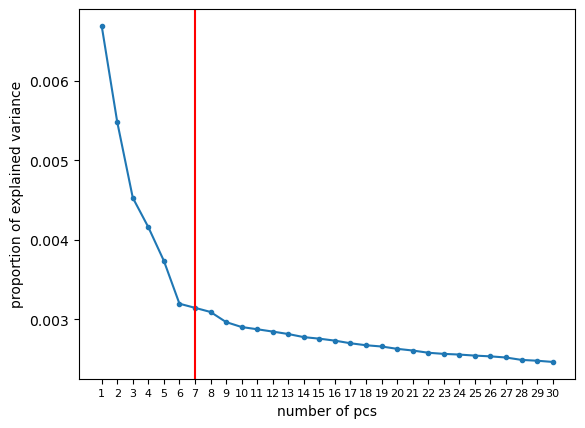

In [100]:
# determine number of pcs to use
# plot explained variance ratios of first 30 pcs
plt.plot(range(1, 31), pca.explained_variance_ratio_[:30], marker = '.')
plt.xticks(ticks = range(1, 31), fontsize = 8)
plt.xlabel('number of pcs')
plt.ylabel('proportion of explained variance')

# find the knee point using the KneeLocator function
knee_locator = KneeLocator(range(1, 31), 
                           pca.explained_variance_ratio_[:30], 
                           curve = 'convex', 
                           direction = 'decreasing',
                           interp_method = 'polynomial')
knee = knee_locator.knee
plt.axvline(x = knee, color = 'red')

print('Knee point:', knee)

The plot above indicates that 7 would be a good possible number of principle components. Visually interpreting the plot, I would suggest either 6 or possibly 9 principle components. 

We will see how much of the given variance these PCA models can predict with our top-performing model so far, the Tuned XGB on the feature-engineered dataset. We will run a loop below testing 5-10 PCs to see how well the model can perform with each number.

In [108]:
# split df_fe into X and y
target = 'avg_grade'
df_fe_y = df_fe[target]
df_fe_X = df_fe.drop(columns = target)

In [109]:
# validate model with train/test split
df_fe_X_train, df_fe_X_test, df_fe_y_train, df_fe_y_test = \
train_test_split(df_fe_X, df_fe_y, random_state = 42)

In [113]:
# try range of 5-10 PCs
for num in range(5, 11):

    # create a pipeline with PCA model
    pca_transformer = make_pipeline(preprocessor2_and_scaler, 
                                   PCA(n_components = num))

    # call our best model so far (Tuned XGB on FE), make pipeline, and fit
    fe_tun_xgb_pca_pipe = make_pipeline(pca_transformer, fe_tun_xgb)
    fe_tun_xgb_pca_pipe.fit(df_fe_X_train, df_fe_y_train)
    
    # evaluate on r2
    print(f'Number of PCs: {num}')
    print('Training R2 on df_fe: ', fe_tun_xgb_pca_pipe.score(df_fe_X_train, 
                                                              df_fe_y_train))
    print('Testing R2 on df_fe: ', fe_tun_xgb_pca_pipe.score(df_fe_X_test, 
                                                             df_fe_y_test))
    print()

Number of PCs: 5
Training R2 on df_fe:  0.6984293830527543
Testing R2 on df_fe:  0.4842804027055473

Number of PCs: 6
Training R2 on df_fe:  0.730188223650344
Testing R2 on df_fe:  0.5095611111499062

Number of PCs: 7
Training R2 on df_fe:  0.7041255655195917
Testing R2 on df_fe:  0.499198970916956

Number of PCs: 8
Training R2 on df_fe:  0.7021310251111362
Testing R2 on df_fe:  0.4993962473020205

Number of PCs: 9
Training R2 on df_fe:  0.7067956623127344
Testing R2 on df_fe:  0.5087961867162316

Number of PCs: 10
Training R2 on df_fe:  0.7173558595404402
Testing R2 on df_fe:  0.516859729395962



Although PCA may make our models faster, with such a large number of features in our dataset, breaking our data down into PCs is losing data that helps our models. We don't need PCA with this data.

# Model Decision (Regression)

Let's see the results of all the models we've made so far.

In [114]:
metrics_df.sort_values(by = 'Test R2', ascending = False)

,Train R2,Test R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train RMSE,Test RMSE
FE Tun XGB,0.973606,9.106307e-01,0.040738,7.565216e-02,7.472473e+09,0.023162,0.060803,1.120203e-01
FE Tun BR,0.986134,9.006598e-01,0.029398,7.988506e-02,1.033142e+11,0.024505,0.044071,1.181041e-01
FE Def RF,0.986042,9.003516e-01,0.029442,7.990925e-02,1.122773e+11,0.024510,0.044216,1.182872e-01
FE Tun GBR,0.981245,8.978792e-01,0.033371,8.113258e-02,5.677381e+09,0.024899,0.051255,1.197456e-01
Tun XGB,0.833574,6.578420e-01,0.112817,1.632414e-01,1.857071e-01,0.485299,0.152680,2.191876e-01
Def RF,0.935126,6.453246e-01,0.660290,1.629727e-01,1.943255e-01,0.484718,0.953249,2.231609e-01
Tun BR,0.935160,6.450013e-01,0.660389,1.630311e-01,1.967819e-01,0.484926,0.953004,2.232626e-01
Tun GBR,0.878626,6.341327e-01,0.938064,1.679331e-01,1.161788e-01,0.499571,0.130387,2.266545e-01
Tun RF,0.931888,6.335185e-01,0.700322,1.707381e-01,1.941178e-01,0.507613,0.976753,2.268446e-01
Tun KNN,0.686886,6.185721e-01,0.156648,1.734479e-01,4.410609e-01,0.514126,0.209423,2.314242e-01


## Summary of Modeling Steps

1. Created dummy and linear regression models.
2. Created default and tuned versions of Decision Tree Regressor, Bagged Tree Regressor, Random Forest Regressor, K-Nearest Neighbors Regressor, Extreme Gradient Boosting Regressor, Light Gradient Boosting Machine Regressor, and Gradient Boosting Regressor models.
3. Feature engineering: selected and transformed columns in dataset.
4. Ran the Tuned XGB, Tuned BR, Default RF, and Tuned GBR on the feature-engineered dataset. 
5. Tried but decided against using PCA.

# Classification

We will now try this problem as a classification problem instead of regression. We will transform the target into categories, and then try classification models to see how well the target class can be predicted.

## Target Classes

- Break down the target column ('avg_grade') into classes (https://registrar.wisc.edu/valid-grades/):
    - A: x == 4.0
    - AB: 3.5 <= x < 4.0
    - B: 3.0 <= x < 3.5
    - BC: 2.5 <= x < 3.0
    - C: 2.0 <= x < 2.5
    - D: 1.0 <= x < 2.0
    - F: x < 1.0

# Next Steps

1. Try to predict other targets (a_proportion, f_proportion)

2. Convert to a classification problem (average grade targets 3.0-4.0, 2.0-3.0, 1.0-2.0, < 1.0, for example), to show ROC visualizations

3. Go back to original data to keep number of grades given per class (size of class variable). 